# Statistical Distributions and their common use

## Types

There are different samplers to use:

### Fitting data to probability distributions

We start with the problem of finding values for the parameters that provide the best fit between the model and the data, called point estimates. First, we need to define what we mean by ‘best fit’. There are two commonly used criteria:

* **Method of moments** chooses the parameters so that the sample moments (typically the sample mean and variance) match the theoretical moments of our chosen distribution.
* **Maximum likelihood** chooses the parameters to maximize the likelihood, which measures how likely it is to observe our given sample.



   Maximum Likelihood
==================

The ***method of moments*** simply assigns the empirical mean and variance to their theoretical counterparts, so that we can solve for the parameters.

So, for the gamma distribution, the mean and variance are:

<div style="font-size: 150%;">  
$$ \hat{\mu} = \bar{X} = \alpha \beta $$
$$ \hat{\sigma}^2 = S^2 = \alpha \beta^2 $$
</div>

**Maximum likelihood** (ML) fitting is usually more work than the method of moments, but it is preferred as the resulting estimator is known to have good theoretical properties. 

There is a ton of theory regarding ML. We will restrict ourselves to the mechanics here.

Say we have some data $y = y_1,y_2,\ldots,y_n$ that is distributed according to some distribution:

<div style="font-size: 120%;">  
$$Pr(Y_i=y_i | \theta)$$
</div>

Going back to the rainfall data, if we are using a gamma distribution we need to maximize:

$$\begin{align}l(\alpha,\beta) &= \sum_{i=1}^n \log[\beta^{\alpha} x^{\alpha-1} e^{-x/\beta}\Gamma(\alpha)^{-1}] \cr 
&= n[(\alpha-1)\overline{\log(x)} - \bar{x}\beta + \alpha\log(\beta) - \log\Gamma(\alpha)]\end{align}$$

(*Its usually easier to work in the log scale*)

where $n = 2012 − 1871 = 141$ and the bar indicates an average over all *i*. We choose $\alpha$ and $\beta$ to maximize $l(\alpha,\beta)$.

Notice $l$ is infinite if any $x$ is zero. We do not have any zeros, but we do have an NA value for one of the October data, which we dealt with above.

### Finding the MLE

To find the maximum of any function, we typically take the *derivative* with respect to the variable to be maximized, set it to zero and solve for that variable. 

$$\frac{\partial l(\alpha,\beta)}{\partial \beta} = n\left(\frac{\alpha}{\beta} - \bar{x}\right) = 0$$

Which can be solved as $\beta = \alpha/\bar{x}$. However, plugging this into the derivative with respect to $\alpha$ yields:

$$\frac{\partial l(\alpha,\beta)}{\partial \alpha} = \log(\alpha) + \overline{\log(x)} - \log(\bar{x}) - \frac{\Gamma(\alpha)'}{\Gamma(\alpha)} = 0$$

This has no closed form solution. We must use ***numerical optimization***!

Numerical optimization alogarithms take an initial "guess" at the solution, and iteratively improve the guess until it gets "close enough" to the answer.

Here, we will use Newton-Raphson algorithm:

<div style="font-size: 120%;">  
$$x_{n+1} = x_n - \frac{f(x_n)}{f'(x_n)}$$
</div>

Which is available to us via SciPy:

In [18]:
from scipy.optimize import newton

Here is a graphical example of how Newtone-Raphson converges on a solution, using an arbitrary function:

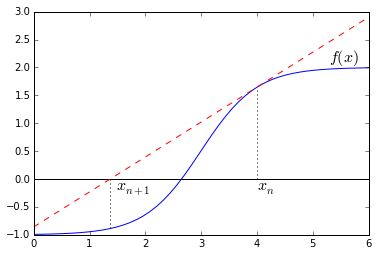

In [19]:
# some function
func = lambda x: 3./(1 + 400*np.exp(-2*x)) - 1
xvals = np.linspace(0, 6)
plt.plot(xvals, func(xvals))
plt.text(5.3, 2.1, '$f(x)$', fontsize=16)
# zero line
plt.plot([0,6], [0,0], 'k-')
# value at step n
plt.plot([4,4], [0,func(4)], 'k:')
plt.text(4, -.2, '$x_n$', fontsize=16)
# tangent line
tanline = lambda x: -0.858 + 0.626*x
plt.plot(xvals, tanline(xvals), 'r--')
# point at step n+1
xprime = 0.858/0.626
plt.plot([xprime, xprime], [tanline(xprime), func(xprime)], 'k:')
plt.text(xprime+.1, -.2, '$x_{n+1}$', fontsize=16)

To apply the Newton-Raphson algorithm, we need a function that returns a vector containing the **first and second derivatives** of the function with respect to the variable of interest. In our case, this is:

In [20]:
from scipy.special import psi, polygamma

dlgamma = lambda m, log_mean, mean_log: np.log(m) - psi(m) - log_mean + mean_log
dl2gamma = lambda m, *args: 1./m - polygamma(1, m)

where `log_mean` and `mean_log` are $\log{\bar{x}}$ and $\overline{\log(x)}$, respectively. `psi` and `polygamma` are complex functions of the Gamma function that result when you take first and second derivatives of that function.

In [21]:
# Calculate statistics
log_mean = precip.mean().apply(np.log)
mean_log = precip.apply(np.log).mean()

Time to optimize!

In [22]:
# Alpha MLE for December
alpha_mle = newton(dlgamma, 2, dl2gamma, args=(log_mean[-1], mean_log[-1]))
alpha_mle

3.5189679152399647

And now plug this back into the solution for beta:

<div style="font-size: 120%;">  
$$ \beta  = \frac{\alpha}{\bar{X}} $$
</div>

In [23]:
beta_mle = alpha_mle/precip.mean()[-1]
beta_mle

0.84261607548413797

### Import libraries 

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm 
import pandas as pd
from theano.printing import pydotprint

import os
import sys

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Import our own library functions

In [2]:
base_path = os.path.abspath('')
sys.path.append(base_path + "/")
os.chdir("../../")
base_path = os.path.abspath('')
sys.path.append(base_path + "/")
import import_folders

# Own graphical library
from graph_lib import gl
import utilities_lib as ul

Base path: /home/montoya/Desktop/bolsa/Trapyng/Code


### Own options and configurations

In [32]:
RANDOM_SEED = 100

folder_images = "../pics/HBM/example_1/"
data_path = "../data/data_HBM/radon.csv"
ul.create_folder_if_needed(folder_images)

## Load the data: 

In [33]:
data = pd.read_csv(data_path)
county_names = data.county.unique()
county_idx = data['county_code'].values

## Realizations of the sampling

The left column consists of a smoothed histogram (using kernel density estimation) of the marginal posteriors of each stochastic random variable while the right column contains the samples of the Markov chain plotted in sequential order.


In [48]:
adjwt = data["adjwt"]
log_radon = data["log_radon"]
floor = data["floor"]
with pm.Model() as model: # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    sigma = pm.HalfCauchy('sigma', beta=10, testval=1.)
    intercept = pm.Normal('Intercept', 0, sd=10)
    x_coeff = pm.Normal('x', 0, sd=10)
    
    # Model equations
    mu_eq = intercept + x_coeff * floor
    
    # Likelihood of observations
    likelihood_obs = pm.Normal('y', mu= mu_eq, 
                        sd=sigma, observed=log_radon)
    
    # Inference!
    trace_NUTS = pm.sample(progressbar=True, tune=1000, njobs=4) # draw posterior samples using NUTS sampling
    trace_VI = pm.fit(random_seed=RANDOM_SEED).sample(1000)
    trace_VI_fullrank = pm.FullRankADVI().fit().sample(1000)
 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x, Intercept, sigma]
Average Loss = 1,162.8: 100%|██████████| 10000/10000 [00:03<00:00, 3312.17it/s]
Finished [100%]: Average Loss = 1,162.4
Average Loss = 1,103.3: 100%|██████████| 10000/10000 [00:05<00:00, 1748.73it/s]
Finished [100%]: Average Loss = 1,103.3


<Figure size 504x504 with 0 Axes>

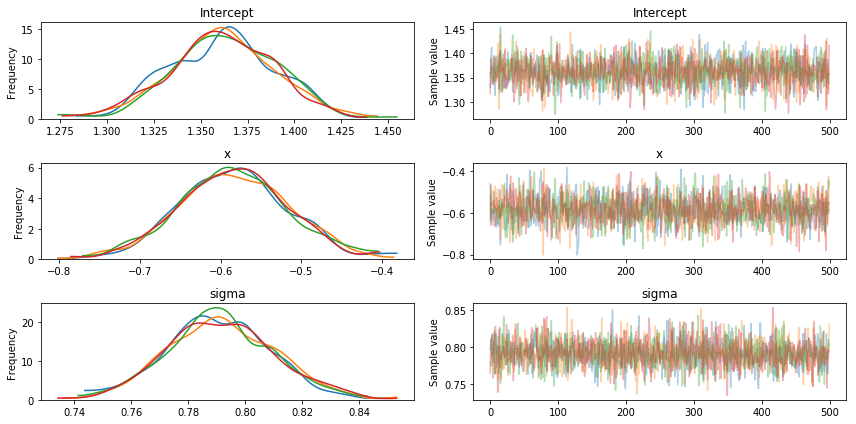

<Figure size 504x504 with 0 Axes>

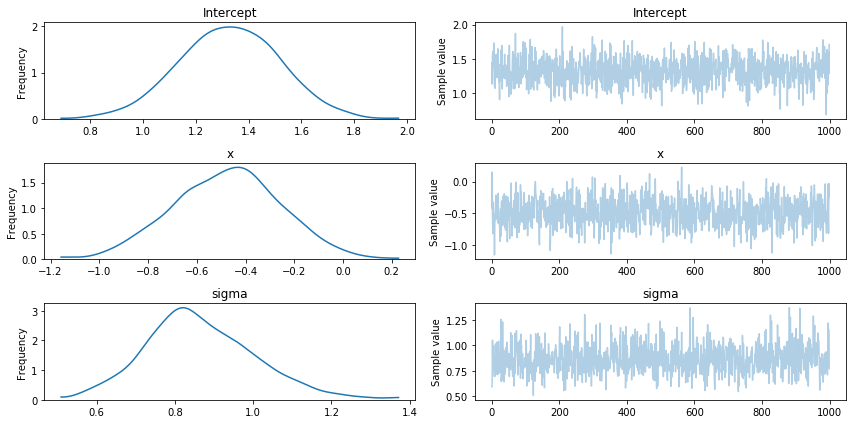

In [49]:
fig = plt.figure(figsize=(7, 7))
pm.traceplot(trace_NUTS)
fig_size = plt.tight_layout();

fig = plt.figure(figsize=(7, 7))
pm.traceplot(trace_VI)
fig_size = plt.tight_layout();


In [57]:
pm.summary(trace_NUTS)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Intercept,1.361698,0.027841,0.000579,1.311122,1.416749,2379.616555,1.000190
x,-0.584749,0.067276,0.001514,-0.723095,-0.461317,1876.833046,0.999079
sigma,0.791006,0.018622,0.000337,0.753022,0.826762,2902.964288,0.999632


In [58]:
pm.summary(trace_VI)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
Intercept,1.324234,0.187983,0.005796,0.970967,1.707374
x,-0.479279,0.218814,0.006570,-0.904930,-0.066090
sigma,0.864774,0.139704,0.004567,0.598275,1.136373


In [59]:
pm.summary(trace_VI_fullrank)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
Intercept,1.359654,0.030094,0.000964,1.296696,1.412794
x,-0.585208,0.075678,0.002179,-0.716739,-0.424229
sigma,0.790747,0.021276,0.000647,0.748494,0.828995


## Plotting the fit of the parameters with built-in func

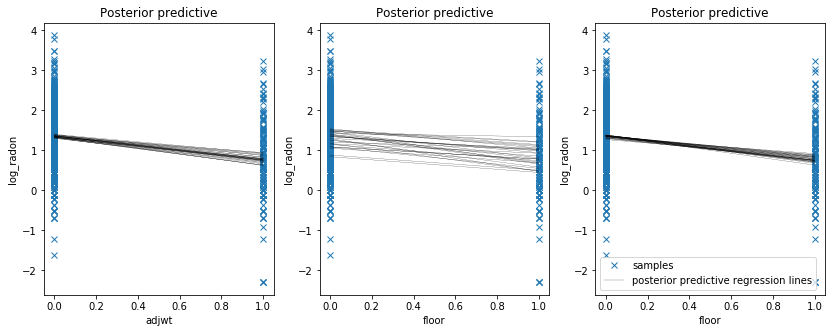

In [66]:
fig = plt.figure(figsize=(14, 5))

ax = fig.add_subplot(131, xlabel='adjwt', ylabel='log_radon', title="NUTS")
ax.plot(floor, log_radon, 'x', label='samples')
pm.plots.plot_posterior_predictive_glm(trace_NUTS,
                                       label='posterior predictive regression lines')

ax = fig.add_subplot(132, xlabel='floor', ylabel='log_radon', title='VI')
ax.plot(floor, log_radon, 'x', label='samples')
pm.plots.plot_posterior_predictive_glm(trace_VI,
                                       label='posterior predictive regression lines')

ax = fig.add_subplot(133, xlabel='floor', ylabel='log_radon', title='VI')
ax.plot(floor, log_radon, 'x', label='samples')
pm.plots.plot_posterior_predictive_glm(trace_VI_fullrank,
                                       label='posterior predictive regression lines')

plt.legend(loc=0);



## Correlations in the posterior distribution of the parameters

We can estimate the posterior statistical dependency between the slope "x" and the "Intercept" and "sigma"

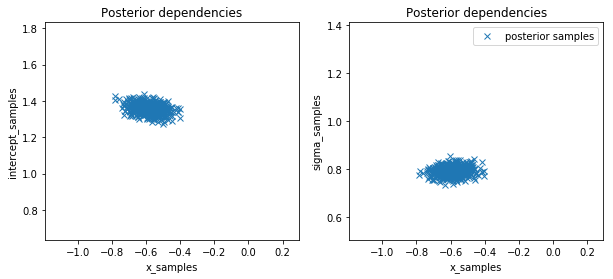

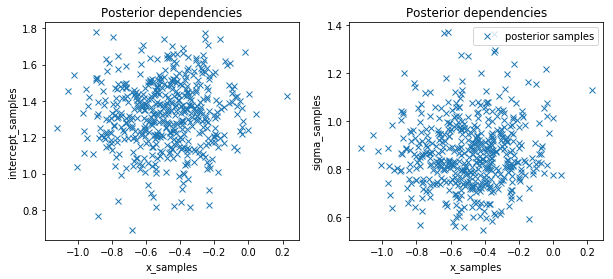

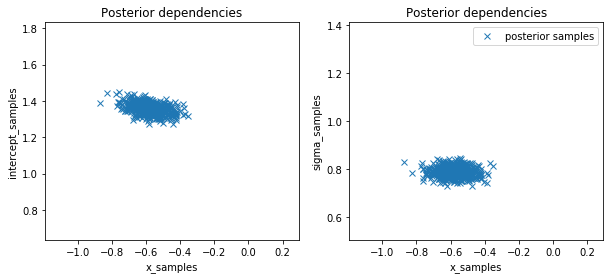

In [72]:
Nsamples = 500

traces = [trace_NUTS, trace_VI, trace_VI_fullrank]

ax1= None; ax2 = None
for trace in traces:
    x_samples = trace['x'][-Nsamples:]
    intercept_samples = trace["Intercept"][-Nsamples:]
    sigma_samples = trace["sigma"][-Nsamples:]


    ## I guess in order to draw samples from this posterior distribution, we draw pairs? 

    fig = plt.figure(figsize=(10, 4))

    ax1 = fig.add_subplot(121, xlabel='x_samples', ylabel='intercept_samples',
                          title='Posterior dependencies', sharex = ax1, sharey = ax1)
    ax1.plot(x_samples, intercept_samples, 'x', label='posterior samples')

    ax2 = fig.add_subplot(122, xlabel='x_samples', ylabel='sigma_samples', 
                          title='Posterior dependencies', sharex = ax2, sharey = ax2)
    ax2.plot(x_samples, sigma_samples, 'x', label='posterior samples')

    plt.legend(loc=0);


We can use these pararameters as well to plot the regression line ourselves: